In [2]:
import os
from PIL import Image
import numpy as np
import keras
from imgaug import augmenters as iaa
# import imgaug as ia
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.layers import Convolution2D, Flatten, Dropout, MaxPooling2D,Dense,Activation


In [4]:
path = 'D:/Users/wechat/WeChat Files/wxid_g6jqg3tpzv9022/FileStorage/File/2019-11/train/train/'
def get_data_from_filenames(filenames):
    images = []
    for file in filenames:
        image = Image.open(file)
        image = image.convert('RGB')
        image = image.resize((100, 100))
        image = np.array(image)
        images.append(image)
        
    return np.array(images)

def get_filenames_and_labels(path):
    filenames = os.listdir(path)
    
    filename_list = []
    labels_list = []
    for filename in filenames:
        filename_list.append(os.path.join(path, filename))
        labels_list.append(float(filename.split('_')[0]))
    return np.array(filename_list), np.array(labels_list)
# a,b = get_filenames_and_labels(path)
# b.shape

def augment_batch(images):
    seq = iaa.Sequential([
        iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
        iaa.Fliplr(0.5), # 0.5 is the probability, horizontally flip 50% of the images
        # iaa.Sometimes(0.5,
        #               iaa.GaussianBlur(sigma=(0, 1.0))
        #              ), 
        iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            # translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-25, 25),
            shear=(-8, 8))
    ],
        
        random_order=True)
    images_aug = seq(images=images)
    return images_aug

def generator_shuffle_aug(path, batch_size=16):
    
    # è¯»åæä»¶å?    image_filenames, labels = get_filenames_and_labels(path)
    
    
    # è®¡ç®å¾çæ»æ°éï¼ç¨ä½å¤å®ä¾æ®
    image_filenames, labels = get_filenames_and_labels(path)
    img_number = len(image_filenames)
    
    idx = 0
    shuffle = np.random.permutation(np.arange(img_number))
    while True:
    #    shuffle = np.random.permutation(np.arange(img_number))
        
        data_shuffle = image_filenames[shuffle]
        label_shuffle = labels[shuffle]
        if idx+batch_size > img_number:
            idx = 0
        start = idx
        idx = idx + batch_size
        
        temp_img_name = data_shuffle[start:start+batch_size]
        temp_label = label_shuffle[start:start+batch_size]
        
        output_images = get_data_from_filenames(temp_img_name)
        output_labels = keras.utils.np_utils.to_categorical(temp_label, 20).astype('float32')
#        output_labels = keras.utils.np_utils.to_categorical(temp_label, 20)
        output_images_aug = augment_batch(output_images)
        output_images_aug = output_images.astype('float32') / 255.
        # yield temp_img_name, temp_label
        yield output_images_aug, output_labels
gen = generator_shuffle_aug(path=path)

(16, 100, 100, 3)
(16, 20)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


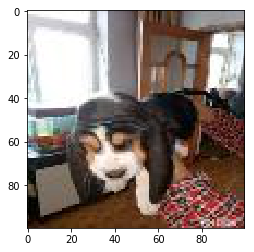

In [7]:
gen = generator_shuffle_aug(path=path)
for i in range(1):
    a, b = next(gen)
print(a.shape)
print(b.shape)
plt.imshow(a[0])
print(b[0])

In [8]:
model = Sequential()

# layer 1
model.add(layers.Convolution2D(
    filters = 32,
    kernel_size = [3,3],
    padding='same',
    input_shape=(100, 100, 3)
))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same',
))

# layer 2
model.add(Convolution2D(
    filters = 64,
    kernel_size = [3,3],
    padding='same',
))
model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same',
    
))

# layer 3
model.add(Convolution2D(
    filters = 128,
    kernel_size = [3,3],
    padding='same',
))
model.add(Activation('relu'))
model.add(MaxPooling2D(
    pool_size=(2,2),
    strides=(2,2),
    padding='same',    
))

# fully connected layer 1
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dense(128))
model.add(Activation('relu'))

model.add(Dense(20))
model.add(Activation('softmax'))

In [10]:
adam = keras.optimizers.Adam(lr=0.0005)

model.compile(optimizer=adam,
             loss='categorical_crossentropy',
             metrics=['accuracy']
             )

In [12]:
model.fit_generator(
#        Generator(path).train(),
                    generator_shuffle_aug(path=path, batch_size=16),
                    # generator_shuffle(path=path),
    # Generator(path).train(),
                    steps_per_epoch=200,
                    epochs=1,
    # shuffle=False
                    )

Epoch 1/1


  1/200 [..............................] - ETA: 3:34 - loss: 2.9737 - acc: 0.0625

  2/200 [..............................] - ETA: 3:08 - loss: 2.9768 - acc: 0.1250

  3/200 [..............................] - ETA: 2:50 - loss: 2.9586 - acc: 0.1667

  4/200 [..............................] - ETA: 2:40 - loss: 2.9574 - acc: 0.1406

  5/200 [..............................] - ETA: 2:33 - loss: 2.9558 - acc: 0.1125

  6/200 [..............................] - ETA: 2:30 - loss: 2.9614 - acc: 0.0938

  7/200 [>.............................] - ETA: 2:27 - loss: 2.9696 - acc: 0.0982

  8/200 [>.............................] - ETA: 2:24 - loss: 2.9643 - acc: 0.1094

  9/200 [>.............................] - ETA: 2:21 - loss: 2.9610 - acc: 0.1042

 10/200 [>.............................] - ETA: 2:19 - loss: 2.9614 - acc: 0.1062

 11/200 [>.............................] - ETA: 2:17 - loss: 2.9757 - acc: 0.0966

 12/200 [>.............................] - ETA: 2:15 - loss: 2.9746 - acc: 0.0938

 13/200 [>.............................] - ETA: 2:14 - loss: 2.9712 - acc: 0.0962

 14/200 [=>............................] - ETA: 2:13 - loss: 2.9690 - acc: 0.0938

 15/200 [=>............................] - ETA: 2:12 - loss: 2.9715 - acc: 0.0875

 16/200 [=>............................] - ETA: 2:10 - loss: 2.9695 - acc: 0.0820

 17/200 [=>............................] - ETA: 2:09 - loss: 2.9764 - acc: 0.0772

 18/200 [=>............................] - ETA: 2:08 - loss: 2.9754 - acc: 0.0764

 19/200 [=>............................] - ETA: 2:07 - loss: 2.9719 - acc: 0.0757

 20/200 [==>...........................] - ETA: 2:05 - loss: 2.9738 - acc: 0.0781

 21/200 [==>...........................] - ETA: 2:04 - loss: 2.9718 - acc: 0.0804

 22/200 [==>...........................] - ETA: 2:04 - loss: 2.9736 - acc: 0.0824

 23/200 [==>...........................] - ETA: 2:02 - loss: 2.9726 - acc: 0.0815

 24/200 [==>...........................] - ETA: 2:02 - loss: 2.9701 - acc: 0.0833

 25/200 [==>...........................] - ETA: 2:01 - loss: 2.9719 - acc: 0.0850

 26/200 [==>...........................] - ETA: 2:00 - loss: 2.9734 - acc: 0.0841

 27/200 [===>..........................] - ETA: 1:59 - loss: 2.9721 - acc: 0.0833

 28/200 [===>..........................] - ETA: 1:58 - loss: 2.9706 - acc: 0.0848

 29/200 [===>..........................] - ETA: 1:57 - loss: 2.9716 - acc: 0.0841

 30/200 [===>..........................] - ETA: 1:56 - loss: 2.9725 - acc: 0.0854

 31/200 [===>..........................] - ETA: 1:56 - loss: 2.9720 - acc: 0.0827

 32/200 [===>..........................] - ETA: 1:55 - loss: 2.9719 - acc: 0.0820

 33/200 [===>..........................] - ETA: 1:54 - loss: 2.9711 - acc: 0.0833

 34/200 [====>.........................] - ETA: 1:53 - loss: 2.9698 - acc: 0.0846

 35/200 [====>.........................] - ETA: 1:52 - loss: 2.9698 - acc: 0.0839

 36/200 [====>.........................] - ETA: 1:51 - loss: 2.9691 - acc: 0.0833

 37/200 [====>.........................] - ETA: 1:51 - loss: 2.9684 - acc: 0.0845

 38/200 [====>.........................] - ETA: 1:50 - loss: 2.9702 - acc: 0.0822

 39/200 [====>.........................] - ETA: 1:49 - loss: 2.9700 - acc: 0.0817

 40/200 [=====>........................] - ETA: 1:49 - loss: 2.9684 - acc: 0.0828

 41/200 [=====>........................] - ETA: 1:48 - loss: 2.9688 - acc: 0.0838

 42/200 [=====>........................] - ETA: 1:47 - loss: 2.9695 - acc: 0.0833

 43/200 [=====>........................] - ETA: 1:46 - loss: 2.9690 - acc: 0.0843

 44/200 [=====>........................] - ETA: 1:46 - loss: 2.9640 - acc: 0.0881

 45/200 [=====>........................] - ETA: 1:45 - loss: 2.9636 - acc: 0.0875

 46/200 [=====>........................] - ETA: 1:44 - loss: 2.9647 - acc: 0.0883

 47/200 [======>.......................] - ETA: 1:43 - loss: 2.9578 - acc: 0.0904

 48/200 [======>.......................] - ETA: 1:42 - loss: 2.9561 - acc: 0.0924

 49/200 [======>.......................] - ETA: 1:42 - loss: 2.9574 - acc: 0.0906

 50/200 [======>.......................] - ETA: 1:41 - loss: 2.9578 - acc: 0.0900

 51/200 [======>.......................] - ETA: 1:40 - loss: 2.9544 - acc: 0.0907

 52/200 [======>.......................] - ETA: 1:39 - loss: 2.9536 - acc: 0.0901

 53/200 [======>.......................] - ETA: 1:39 - loss: 2.9547 - acc: 0.0884

 54/200 [=======>......................] - ETA: 1:38 - loss: 2.9528 - acc: 0.0880

 55/200 [=======>......................] - ETA: 1:37 - loss: 2.9538 - acc: 0.0875

 56/200 [=======>......................] - ETA: 1:36 - loss: 2.9525 - acc: 0.0871

 57/200 [=======>......................] - ETA: 1:36 - loss: 2.9504 - acc: 0.0866

 58/200 [=======>......................] - ETA: 1:35 - loss: 2.9490 - acc: 0.0884

 59/200 [=======>......................] - ETA: 1:34 - loss: 2.9475 - acc: 0.0890

 60/200 [========>.....................] - ETA: 1:34 - loss: 2.9452 - acc: 0.0896

 61/200 [========>.....................] - ETA: 1:33 - loss: 2.9457 - acc: 0.0881

 62/200 [========>.....................] - ETA: 1:32 - loss: 2.9396 - acc: 0.0887

 63/200 [========>.....................] - ETA: 1:32 - loss: 2.9373 - acc: 0.0893

 64/200 [========>.....................] - ETA: 1:31 - loss: 2.9362 - acc: 0.0889

 65/200 [========>.....................] - ETA: 1:30 - loss: 2.9343 - acc: 0.0894

 66/200 [========>.....................] - ETA: 1:29 - loss: 2.9335 - acc: 0.0909

 67/200 [=========>....................] - ETA: 1:29 - loss: 2.9305 - acc: 0.0924

 68/200 [=========>....................] - ETA: 1:28 - loss: 2.9293 - acc: 0.0938

 69/200 [=========>....................] - ETA: 1:27 - loss: 2.9248 - acc: 0.0951

 70/200 [=========>....................] - ETA: 1:27 - loss: 2.9288 - acc: 0.0955

 71/200 [=========>....................] - ETA: 1:26 - loss: 2.9307 - acc: 0.0960

 72/200 [=========>....................] - ETA: 1:25 - loss: 2.9282 - acc: 0.0981

 73/200 [=========>....................] - ETA: 1:25 - loss: 2.9284 - acc: 0.0976

 74/200 [==========>...................] - ETA: 1:24 - loss: 2.9283 - acc: 0.0980

 75/200 [==========>...................] - ETA: 1:23 - loss: 2.9296 - acc: 0.0967

 76/200 [==========>...................] - ETA: 1:23 - loss: 2.9279 - acc: 0.0979

 77/200 [==========>...................] - ETA: 1:22 - loss: 2.9288 - acc: 0.0974

 78/200 [==========>...................] - ETA: 1:22 - loss: 2.9293 - acc: 0.0962

 79/200 [==========>...................] - ETA: 1:21 - loss: 2.9286 - acc: 0.0973

 80/200 [===========>..................] - ETA: 1:21 - loss: 2.9291 - acc: 0.0977

 81/200 [===========>..................] - ETA: 1:20 - loss: 2.9281 - acc: 0.0980

 82/200 [===========>..................] - ETA: 1:19 - loss: 2.9273 - acc: 0.0983

 83/200 [===========>..................] - ETA: 1:19 - loss: 2.9280 - acc: 0.0986

 84/200 [===========>..................] - ETA: 1:18 - loss: 2.9285 - acc: 0.0975

 85/200 [===========>..................] - ETA: 1:17 - loss: 2.9310 - acc: 0.0971

 86/200 [===========>..................] - ETA: 1:17 - loss: 2.9305 - acc: 0.0967

 87/200 [============>.................] - ETA: 1:16 - loss: 2.9300 - acc: 0.0970

 88/200 [============>.................] - ETA: 1:15 - loss: 2.9308 - acc: 0.0966

 89/200 [============>.................] - ETA: 1:15 - loss: 2.9275 - acc: 0.0983

 90/200 [============>.................] - ETA: 1:14 - loss: 2.9258 - acc: 0.0979

 91/200 [============>.................] - ETA: 1:13 - loss: 2.9257 - acc: 0.0975

 92/200 [============>.................] - ETA: 1:13 - loss: 2.9275 - acc: 0.0965

 93/200 [============>.................] - ETA: 1:12 - loss: 2.9256 - acc: 0.0968

 94/200 [=============>................] - ETA: 1:11 - loss: 2.9253 - acc: 0.0957

 95/200 [=============>................] - ETA: 1:10 - loss: 2.9254 - acc: 0.0954

 96/200 [=============>................] - ETA: 1:10 - loss: 2.9248 - acc: 0.0951

 97/200 [=============>................] - ETA: 1:09 - loss: 2.9241 - acc: 0.0947

 98/200 [=============>................] - ETA: 1:08 - loss: 2.9251 - acc: 0.0944

 99/200 [=============>................] - ETA: 1:08 - loss: 2.9246 - acc: 0.0953

100/200 [==============>...............] - ETA: 1:07 - loss: 2.9236 - acc: 0.0956

101/200 [==============>...............] - ETA: 1:06 - loss: 2.9227 - acc: 0.0959

102/200 [==============>...............] - ETA: 1:06 - loss: 2.9205 - acc: 0.0968

103/200 [==============>...............] - ETA: 1:05 - loss: 2.9202 - acc: 0.0965

104/200 [==============>...............] - ETA: 1:04 - loss: 2.9198 - acc: 0.0968

105/200 [==============>...............] - ETA: 1:04 - loss: 2.9191 - acc: 0.0970

106/200 [==============>...............] - ETA: 1:03 - loss: 2.9197 - acc: 0.0967

107/200 [===============>..............] - ETA: 1:02 - loss: 2.9186 - acc: 0.0975

108/200 [===============>..............] - ETA: 1:02 - loss: 2.9156 - acc: 0.0990

109/200 [===============>..............] - ETA: 1:01 - loss: 2.9173 - acc: 0.0981

110/200 [===============>..............] - ETA: 1:00 - loss: 2.9148 - acc: 0.0989

111/200 [===============>..............] - ETA: 1:00 - loss: 2.9138 - acc: 0.0997

112/200 [===============>..............] - ETA: 59s - loss: 2.9130 - acc: 0.0999 

113/200 [===============>..............] - ETA: 58s - loss: 2.9120 - acc: 0.1007

114/200 [================>.............] - ETA: 57s - loss: 2.9088 - acc: 0.1014

115/200 [================>.............] - ETA: 57s - loss: 2.9091 - acc: 0.1016

116/200 [================>.............] - ETA: 56s - loss: 2.9090 - acc: 0.1013

117/200 [================>.............] - ETA: 55s - loss: 2.9093 - acc: 0.1010

118/200 [================>.............] - ETA: 55s - loss: 2.9063 - acc: 0.1017

119/200 [================>.............] - ETA: 54s - loss: 2.9059 - acc: 0.1024

120/200 [=================>............] - ETA: 53s - loss: 2.9014 - acc: 0.1052

121/200 [=================>............] - ETA: 53s - loss: 2.9024 - acc: 0.1043

122/200 [=================>............] - ETA: 52s - loss: 2.9031 - acc: 0.1035

123/200 [=================>............] - ETA: 51s - loss: 2.9035 - acc: 0.1037

124/200 [=================>............] - ETA: 51s - loss: 2.9043 - acc: 0.1033

125/200 [=================>............] - ETA: 50s - loss: 2.9043 - acc: 0.1030

126/200 [=================>............] - ETA: 49s - loss: 2.9055 - acc: 0.1027

127/200 [==================>...........] - ETA: 49s - loss: 2.9056 - acc: 0.1029

128/200 [==================>...........] - ETA: 48s - loss: 2.9054 - acc: 0.1025

129/200 [==================>...........] - ETA: 47s - loss: 2.9050 - acc: 0.1027

130/200 [==================>...........] - ETA: 47s - loss: 2.9050 - acc: 0.1024

131/200 [==================>...........] - ETA: 46s - loss: 2.9067 - acc: 0.1016

132/200 [==================>...........] - ETA: 45s - loss: 2.9062 - acc: 0.1009

133/200 [==================>...........] - ETA: 45s - loss: 2.9056 - acc: 0.1006

134/200 [===================>..........] - ETA: 44s - loss: 2.9058 - acc: 0.1003

135/200 [===================>..........] - ETA: 43s - loss: 2.9069 - acc: 0.0995

136/200 [===================>..........] - ETA: 43s - loss: 2.9073 - acc: 0.0993

137/200 [===================>..........] - ETA: 42s - loss: 2.9061 - acc: 0.0995

138/200 [===================>..........] - ETA: 41s - loss: 2.9066 - acc: 0.0987

139/200 [===================>..........] - ETA: 41s - loss: 2.9059 - acc: 0.0980

140/200 [====================>.........] - ETA: 40s - loss: 2.9059 - acc: 0.0982

141/200 [====================>.........] - ETA: 39s - loss: 2.9064 - acc: 0.0984

142/200 [====================>.........] - ETA: 39s - loss: 2.9066 - acc: 0.0982

143/200 [====================>.........] - ETA: 38s - loss: 2.9064 - acc: 0.0975

144/200 [====================>.........] - ETA: 37s - loss: 2.9062 - acc: 0.0977

145/200 [====================>.........] - ETA: 37s - loss: 2.9068 - acc: 0.0978

146/200 [====================>.........] - ETA: 36s - loss: 2.9068 - acc: 0.0976

147/200 [=====================>........] - ETA: 35s - loss: 2.9066 - acc: 0.0978

148/200 [=====================>........] - ETA: 35s - loss: 2.9069 - acc: 0.0971

149/200 [=====================>........] - ETA: 34s - loss: 2.9076 - acc: 0.0969

150/200 [=====================>........] - ETA: 33s - loss: 2.9069 - acc: 0.0971

151/200 [=====================>........] - ETA: 32s - loss: 2.9057 - acc: 0.0973

152/200 [=====================>........] - ETA: 32s - loss: 2.9055 - acc: 0.0970

153/200 [=====================>........] - ETA: 31s - loss: 2.9043 - acc: 0.0980

154/200 [======================>.......] - ETA: 30s - loss: 2.9041 - acc: 0.0978

155/200 [======================>.......] - ETA: 30s - loss: 2.9035 - acc: 0.0988

156/200 [======================>.......] - ETA: 29s - loss: 2.9029 - acc: 0.0986

157/200 [======================>.......] - ETA: 28s - loss: 2.9021 - acc: 0.0991

158/200 [======================>.......] - ETA: 28s - loss: 2.9017 - acc: 0.0993

159/200 [======================>.......] - ETA: 27s - loss: 2.9025 - acc: 0.0994

160/200 [=======================>......] - ETA: 26s - loss: 2.9021 - acc: 0.1000

161/200 [=======================>......] - ETA: 26s - loss: 2.9022 - acc: 0.0998

162/200 [=======================>......] - ETA: 25s - loss: 2.9011 - acc: 0.0999

163/200 [=======================>......] - ETA: 24s - loss: 2.8997 - acc: 0.1001

164/200 [=======================>......] - ETA: 24s - loss: 2.9005 - acc: 0.1002

165/200 [=======================>......] - ETA: 23s - loss: 2.8997 - acc: 0.0996

166/200 [=======================>......] - ETA: 22s - loss: 2.9004 - acc: 0.0994

167/200 [========================>.....] - ETA: 22s - loss: 2.8984 - acc: 0.0996

168/200 [========================>.....] - ETA: 21s - loss: 2.8979 - acc: 0.0997

169/200 [========================>.....] - ETA: 20s - loss: 2.8963 - acc: 0.0999

170/200 [========================>.....] - ETA: 20s - loss: 2.8953 - acc: 0.1000

171/200 [========================>.....] - ETA: 19s - loss: 2.8958 - acc: 0.0994

172/200 [========================>.....] - ETA: 18s - loss: 2.8940 - acc: 0.1003

173/200 [========================>.....] - ETA: 18s - loss: 2.8942 - acc: 0.1001

174/200 [=========================>....] - ETA: 17s - loss: 2.8936 - acc: 0.1002

175/200 [=========================>....] - ETA: 16s - loss: 2.8944 - acc: 0.0996

176/200 [=========================>....] - ETA: 16s - loss: 2.8933 - acc: 0.0994

177/200 [=========================>....] - ETA: 15s - loss: 2.8924 - acc: 0.0992

178/200 [=========================>....] - ETA: 14s - loss: 2.8916 - acc: 0.0994

179/200 [=========================>....] - ETA: 14s - loss: 2.8906 - acc: 0.1002

180/200 [==========================>...] - ETA: 13s - loss: 2.8899 - acc: 0.1000

181/200 [==========================>...] - ETA: 12s - loss: 2.8893 - acc: 0.1005

182/200 [==========================>...] - ETA: 12s - loss: 2.8883 - acc: 0.1010

183/200 [==========================>...] - ETA: 11s - loss: 2.8879 - acc: 0.1008

184/200 [==========================>...] - ETA: 10s - loss: 2.8884 - acc: 0.1002

185/200 [==========================>...] - ETA: 10s - loss: 2.8886 - acc: 0.1000

186/200 [==========================>...] - ETA: 9s - loss: 2.8875 - acc: 0.0998 

187/200 [===========================>..] - ETA: 8s - loss: 2.8858 - acc: 0.0993

188/200 [===========================>..] - ETA: 8s - loss: 2.8846 - acc: 0.0997

189/200 [===========================>..] - ETA: 7s - loss: 2.8857 - acc: 0.0992

190/200 [===========================>..] - ETA: 6s - loss: 2.8861 - acc: 0.0987

191/200 [===========================>..] - ETA: 6s - loss: 2.8860 - acc: 0.0985

192/200 [===========================>..] - ETA: 5s - loss: 2.8865 - acc: 0.0990

193/200 [===========================>..] - ETA: 4s - loss: 2.8859 - acc: 0.0991

194/200 [============================>.] - ETA: 4s - loss: 2.8856 - acc: 0.0992

195/200 [============================>.] - ETA: 3s - loss: 2.8859 - acc: 0.0990

196/200 [============================>.] - ETA: 2s - loss: 2.8847 - acc: 0.0995

197/200 [============================>.] - ETA: 2s - loss: 2.8840 - acc: 0.0996

198/200 [============================>.] - ETA: 1s - loss: 2.8838 - acc: 0.0997

199/200 [============================>.] - ETA: 0s - loss: 2.8841 - acc: 0.0999

200/200 [==============================] - 136s 679ms/step - loss: 2.8836 - acc: 0.1003


In [13]:
names = os.listdir(path)
print(names[0])
print(names[1000])
images = [os.path.join(path, name) for name in names]
images = get_data_from_filenames(images)
predictions = model.predict(images)
print(predictions[0].argmax())
print(predictions[1000].argmax())

0_0.jpg
15_115.jpg


7
3


In [3]:
filename = ['a', 'b']
filename[1]

'b'